In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'IFF'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-12-31,756,-428,328,90,479,494,569,1711,675,...,216,0,8,518,934,1976,201,-45,81.5,2015-03-01
1,2015-03-31,775,-429,346,128,444,525,536,1754,675,...,216,0,8,487,935,1940,32,-19,80.9,2015-05-05
2,2015-06-30,768,-423,345,105,377,566,562,1722,753,...,242,0,9,525,989,2031,135,-19,80.9,2015-08-04
3,2015-09-30,765,-418,347,106,272,570,589,1639,932,...,254,0,133,687,1058,2320,128,-29,80.9,2015-11-04
4,2015-12-31,716,-403,313,79,182,538,572,1437,941,...,286,0,132,725,935,2112,139,-34,80.9,2016-02-29


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2023-09-30,2023-11-04,255.0,2820,-1896,924,27,629,1831,2549,...,8381,33395,1112,0,1142,3420,9159,16417,420,-100
36,2023-12-31,2024-02-29,255.0,2703,-1843,860,-2609,709,1726,2477,...,8357,30978,1378,0,885,3758,9186,16336,644,-113
37,2024-03-31,2024-05-06,256.0,2899,-1875,1024,61,732,1977,2411,...,8116,30642,1346,0,312,3820,9150,16316,99,-118
38,2024-06-30,2024-08-05,256.0,2889,-1821,1068,170,671,1775,2160,...,6881,29543,1272,0,783,3425,8596,15289,237,-82
39,2024-09-30,2024-11-04,257.0,2925,-1873,1052,60,567,1772,2200,...,6770,29928,1211,0,468,3218,8631,15118,366,-103


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-09-30,2023-11-04,255.0,2820,-1896,924,27,629,1831,2549,...,33395,1112,0,1142,3420,9159,16417,420,-100,1
36,2023-12-31,2024-02-29,255.0,2703,-1843,860,-2609,709,1726,2477,...,30978,1378,0,885,3758,9186,16336,644,-113,1
37,2024-03-31,2024-05-06,256.0,2899,-1875,1024,61,732,1977,2411,...,30642,1346,0,312,3820,9150,16316,99,-118,1
38,2024-06-30,2024-08-05,256.0,2889,-1821,1068,170,671,1775,2160,...,29543,1272,0,783,3425,8596,15289,237,-82,1
39,2024-09-30,2024-11-04,257.0,2925,-1873,1052,60,567,1772,2200,...,29928,1211,0,468,3218,8631,15118,366,-103,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-09-30,2023-11-04,255.0,2820.0,-1896.0,924.0,27.0,629.0,1831.0,2549.0,...,33395.0,1112.0,0.0,1142.0,3420.0,9159.0,16417.0,420.0,-100.0,1
36,2023-12-31,2024-02-29,255.0,2703.0,-1843.0,860.0,-2609.0,709.0,1726.0,2477.0,...,30978.0,1378.0,0.0,885.0,3758.0,9186.0,16336.0,644.0,-113.0,1
37,2024-03-31,2024-05-06,256.0,2899.0,-1875.0,1024.0,61.0,732.0,1977.0,2411.0,...,30642.0,1346.0,0.0,312.0,3820.0,9150.0,16316.0,99.0,-118.0,1
38,2024-06-30,2024-08-05,256.0,2889.0,-1821.0,1068.0,170.0,671.0,1775.0,2160.0,...,29543.0,1272.0,0.0,783.0,3425.0,8596.0,15289.0,237.0,-82.0,1
39,2024-09-30,2024-11-04,257.0,2925.0,-1873.0,1052.0,60.0,567.0,1772.0,2200.0,...,29928.0,1211.0,0.0,468.0,3218.0,8631.0,15118.0,366.0,-103.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-03-02,93.781487,2014-12-31,756.0,0.0,18.638037,81.5,0.0,0.0,479.0,...,0.434621,0.565379,0.0,0.0,0.0,0.0,0.433862,0.119048,0.0,0.0
1,2015-03-09,93.017143,2014-12-31,756.0,0.0,18.638037,81.5,0.0,0.0,479.0,...,0.434621,0.565379,0.0,0.0,0.0,0.0,0.433862,0.119048,0.0,0.0
2,2015-03-16,94.498611,2014-12-31,756.0,0.0,18.638037,81.5,0.0,0.0,479.0,...,0.434621,0.565379,0.0,0.0,0.0,0.0,0.433862,0.119048,0.0,0.0
3,2015-03-23,92.339439,2014-12-31,756.0,0.0,18.638037,81.5,0.0,0.0,479.0,...,0.434621,0.565379,0.0,0.0,0.0,0.0,0.433862,0.119048,0.0,0.0
4,2015-03-30,92.870155,2014-12-31,756.0,0.0,18.638037,81.5,0.0,0.0,479.0,...,0.434621,0.565379,0.0,0.0,0.0,0.0,0.433862,0.119048,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-03-02,93.781487,2014-12-31,756.0,0.0,18.638037,81.5,0.0,0.0,479.0,...,0.0,0.433862,0.119048,0.0,0.0,inf,5.031726,inf,inf,inf
1,2015-03-09,93.017143,2014-12-31,756.0,0.0,18.638037,81.5,0.0,0.0,479.0,...,0.0,0.433862,0.119048,0.0,0.0,inf,4.990716,inf,inf,inf
2,2015-03-16,94.498611,2014-12-31,756.0,0.0,18.638037,81.5,0.0,0.0,479.0,...,0.0,0.433862,0.119048,0.0,0.0,inf,5.070202,inf,inf,inf
3,2015-03-23,92.339439,2014-12-31,756.0,0.0,18.638037,81.5,0.0,0.0,479.0,...,0.0,0.433862,0.119048,0.0,0.0,inf,4.954354,inf,inf,inf
4,2015-03-30,92.870155,2014-12-31,756.0,0.0,18.638037,81.5,0.0,0.0,479.0,...,0.0,0.433862,0.119048,0.0,0.0,inf,4.982829,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

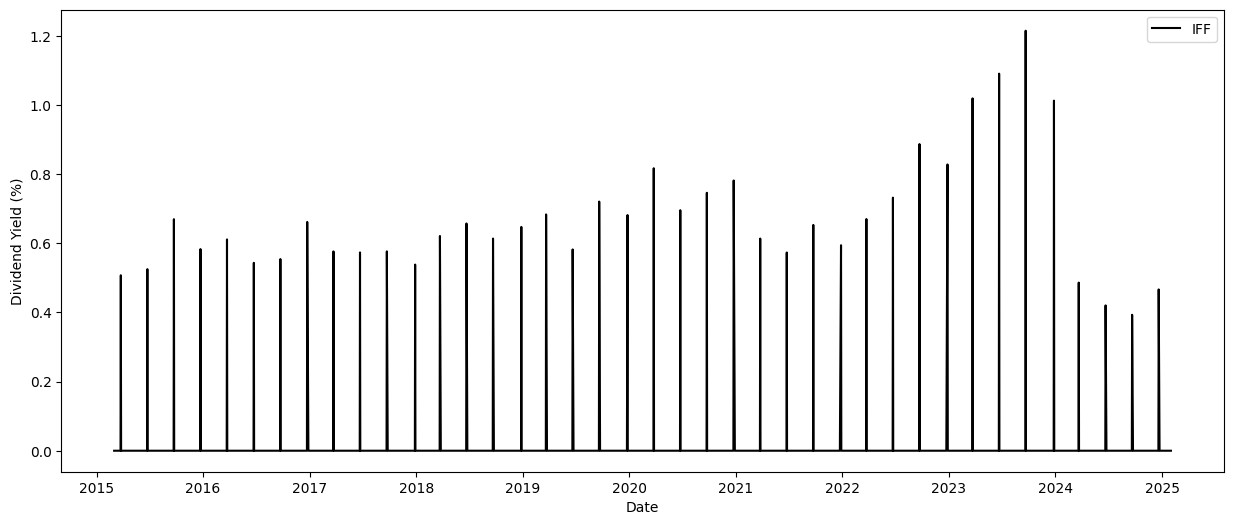

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


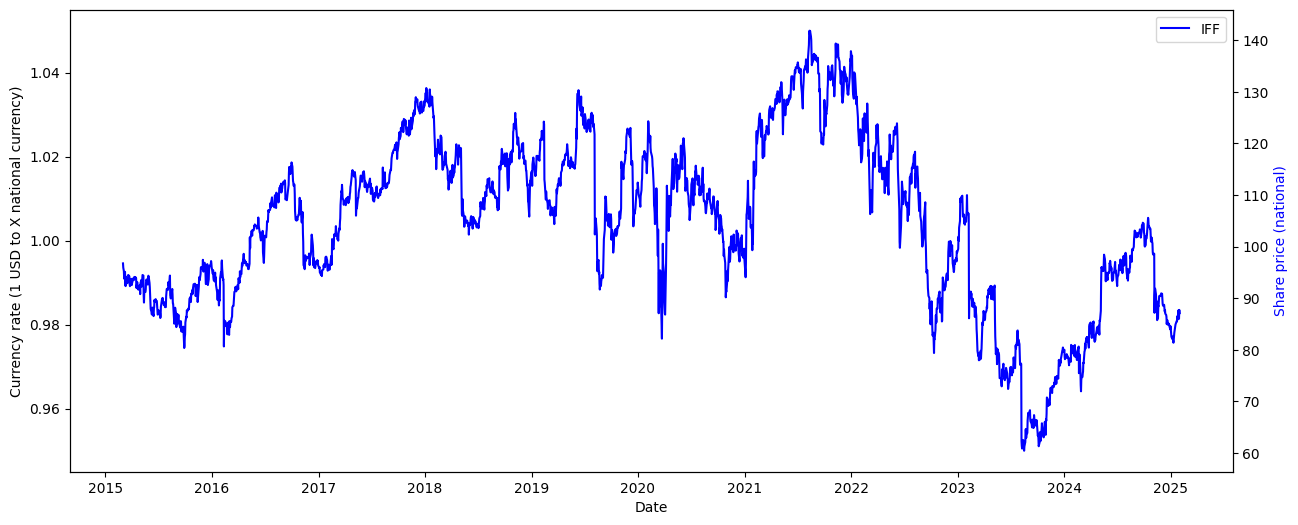

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

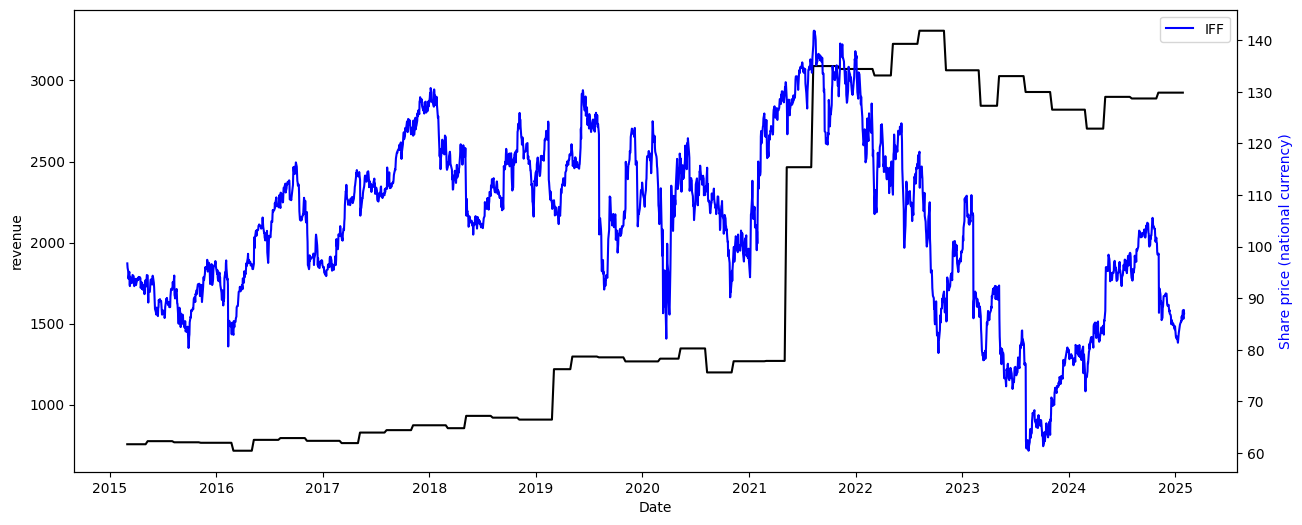

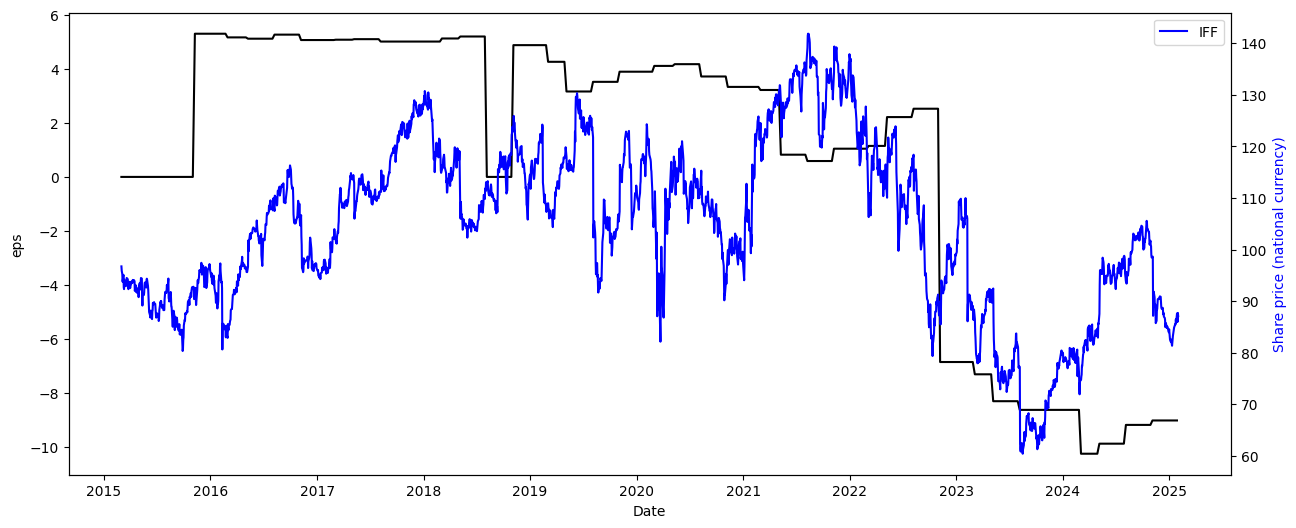

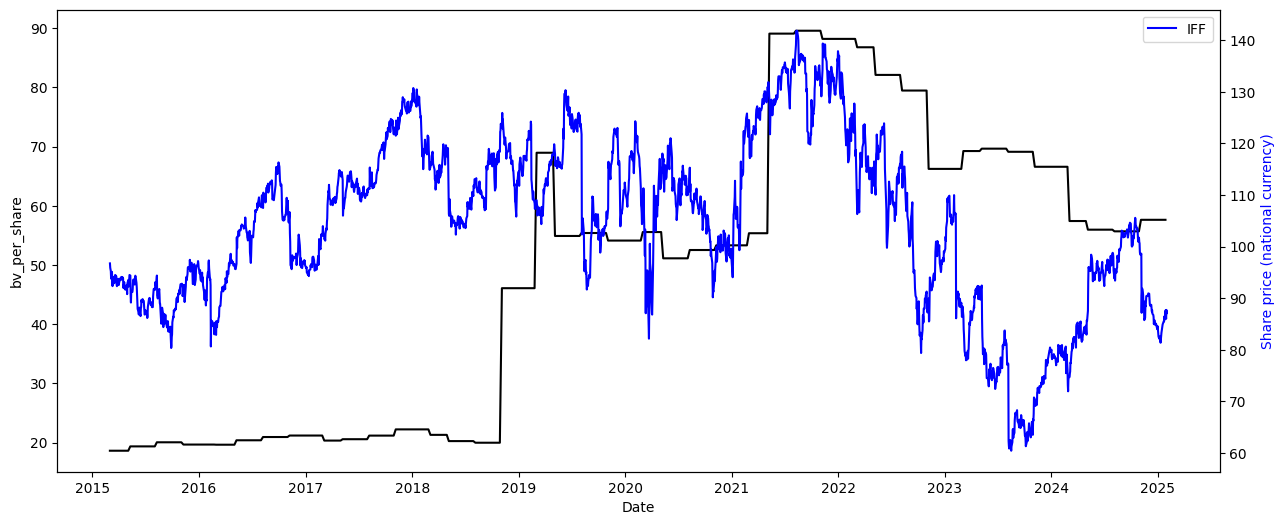

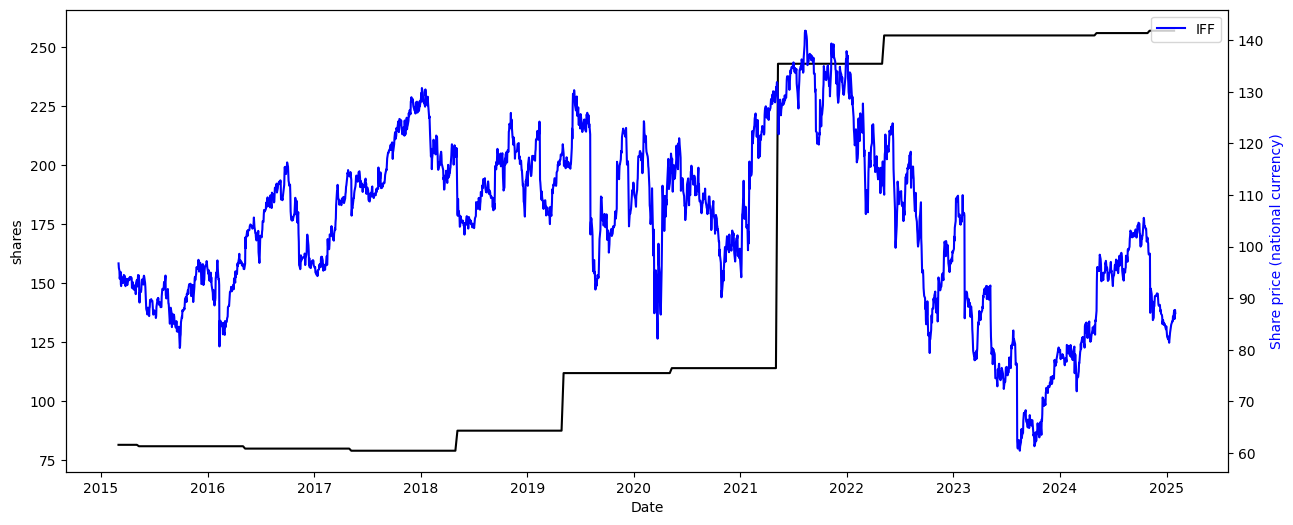

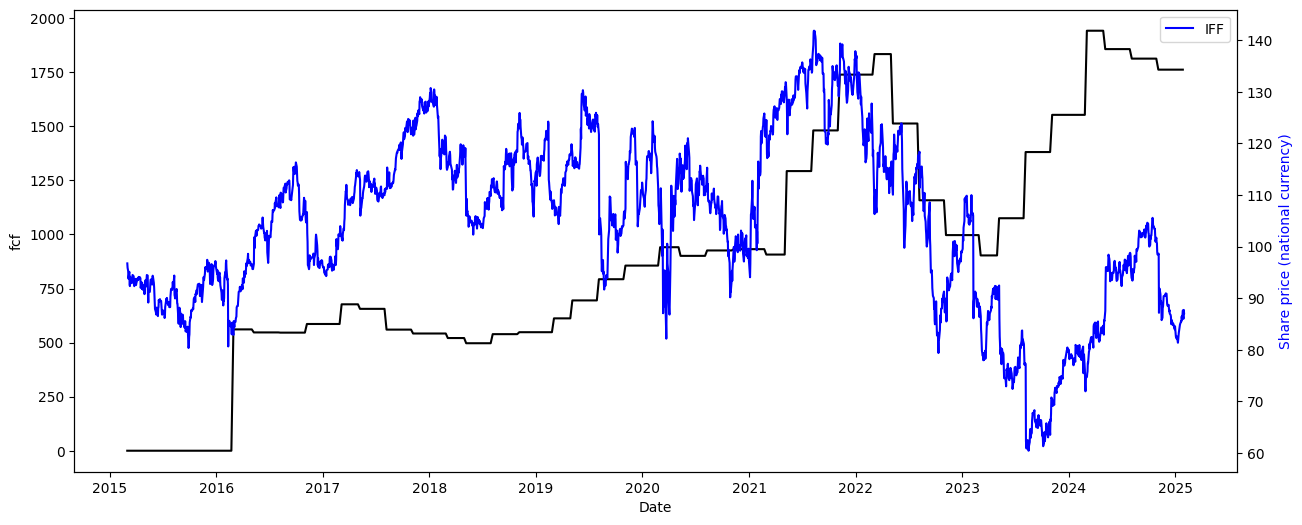

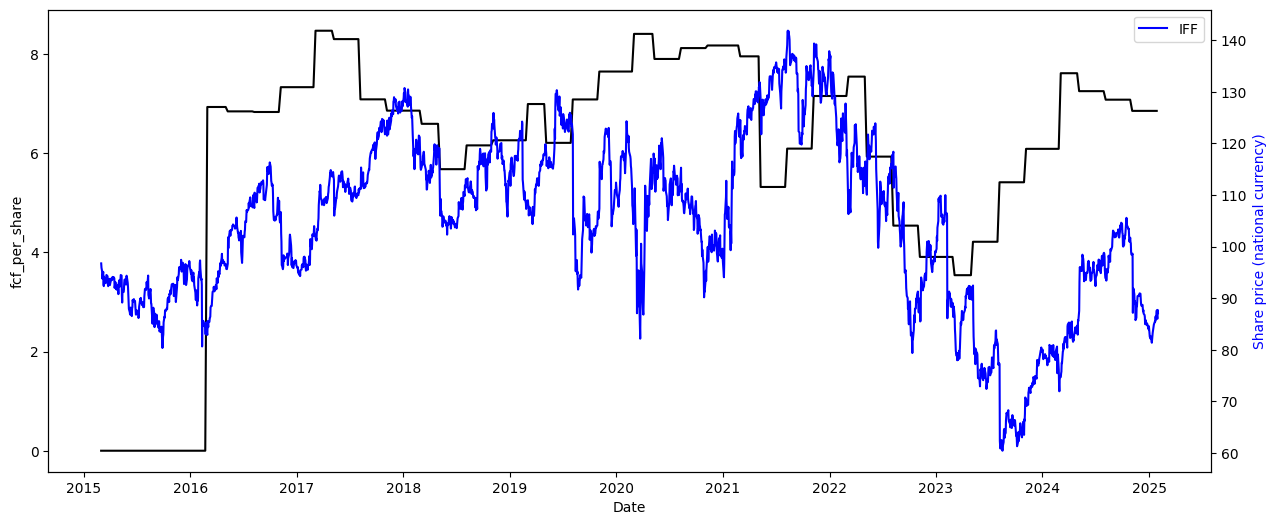

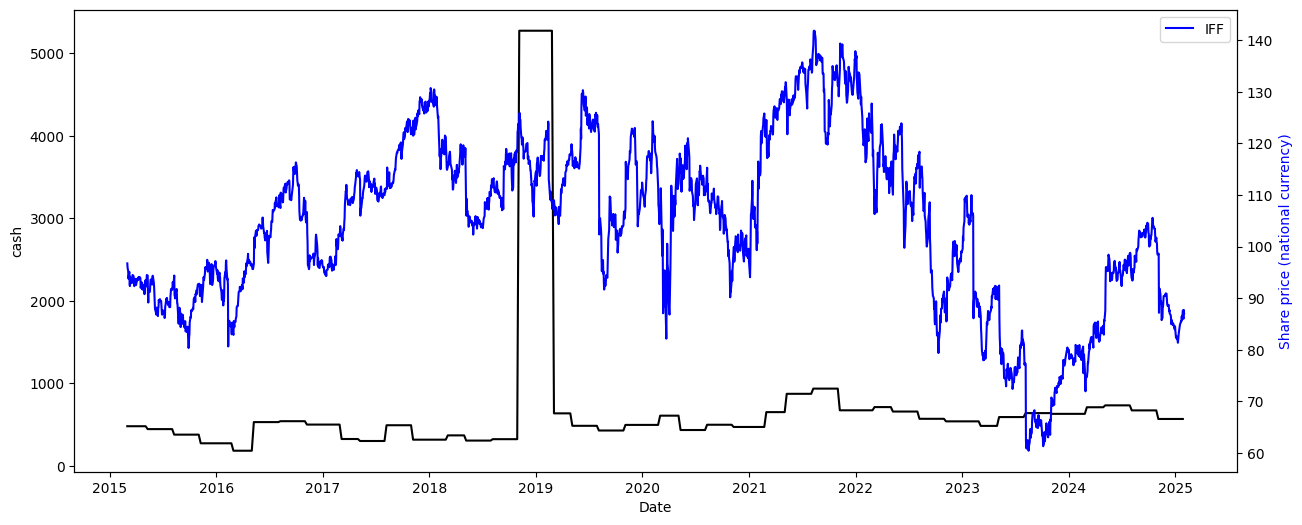

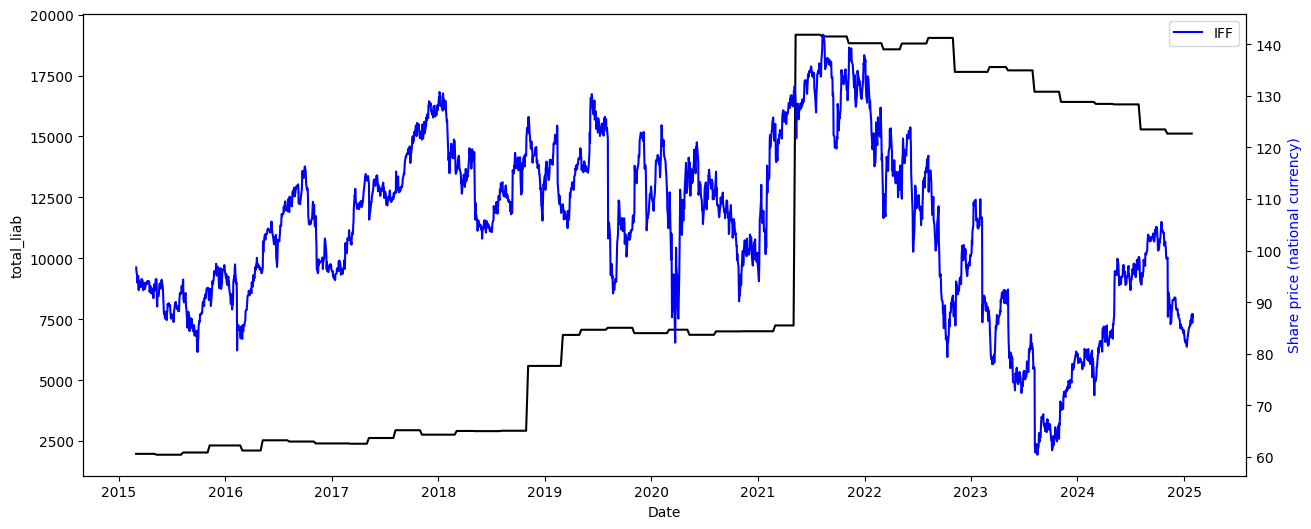

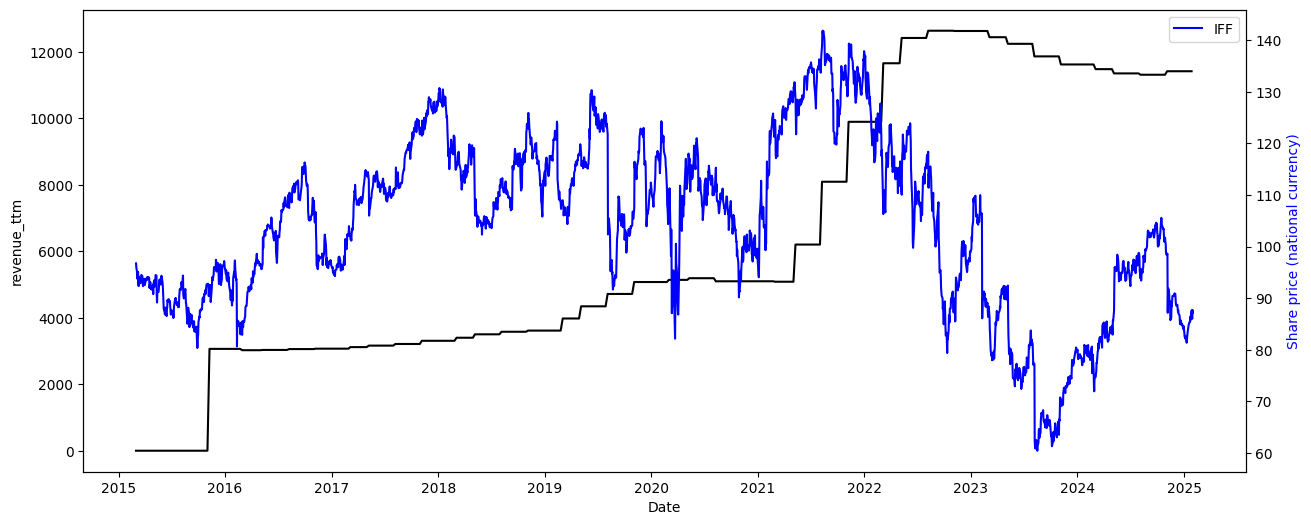

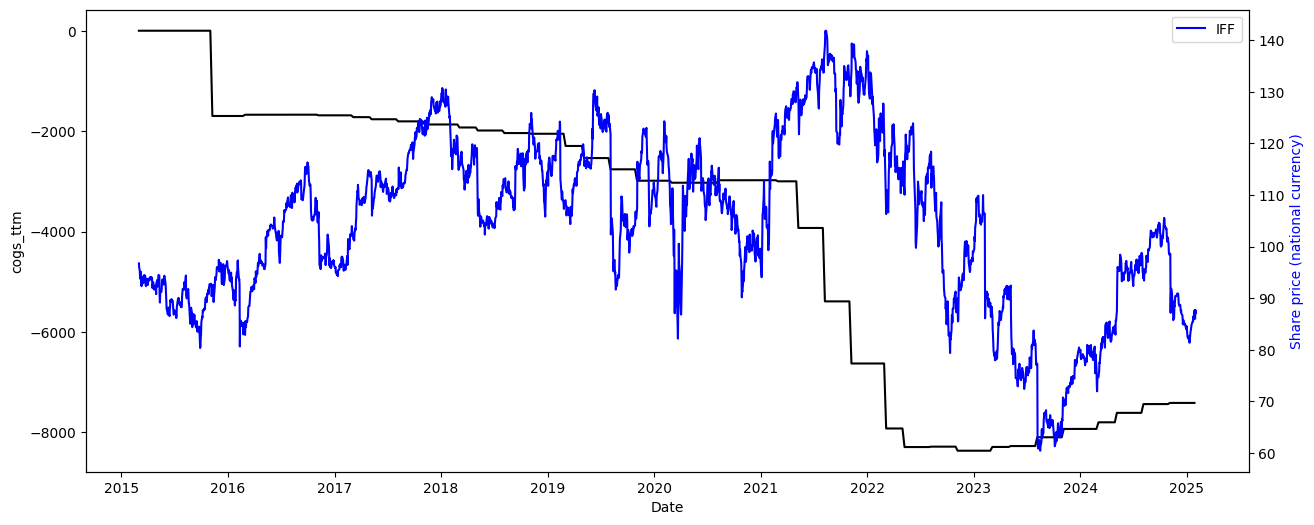

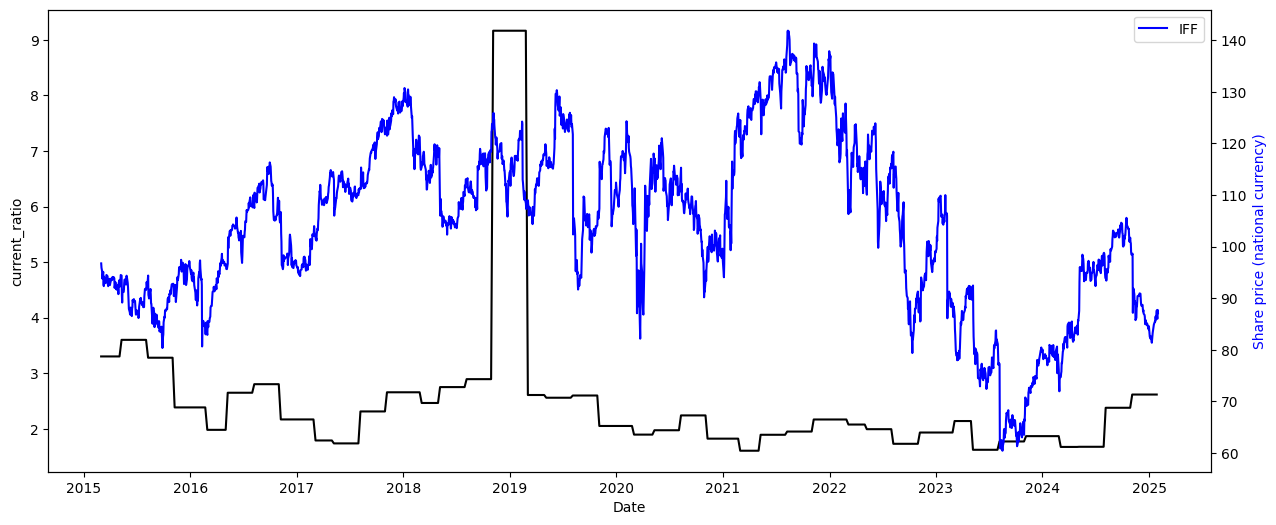

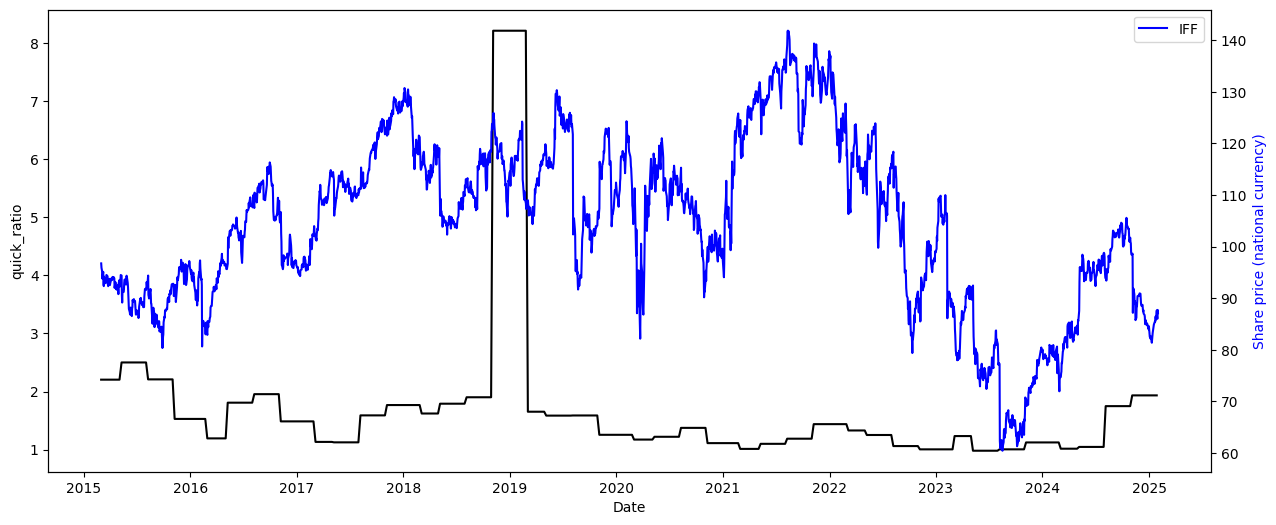

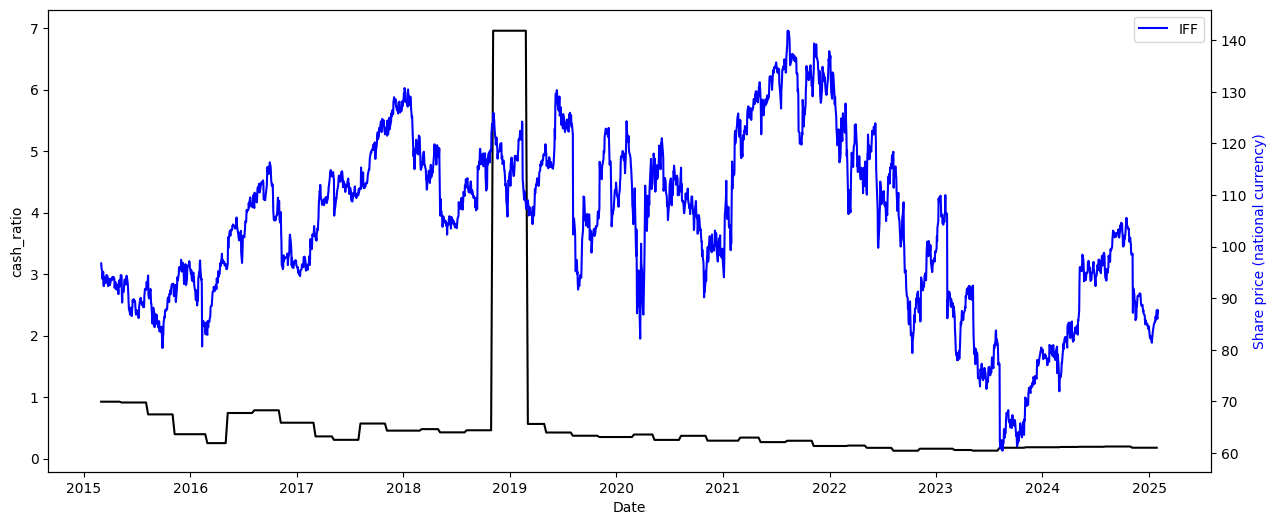

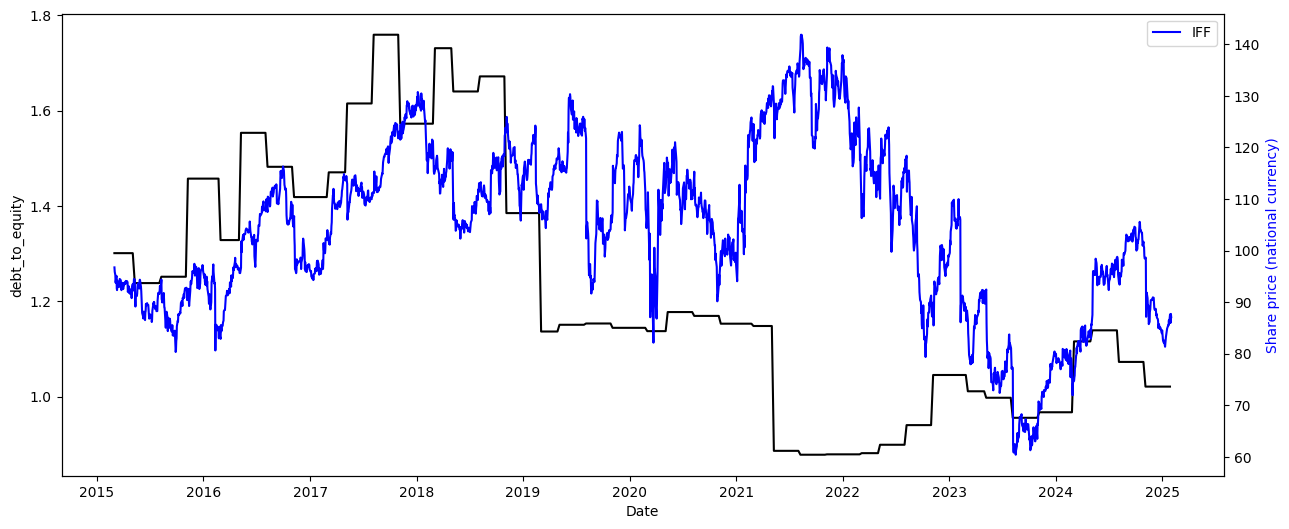

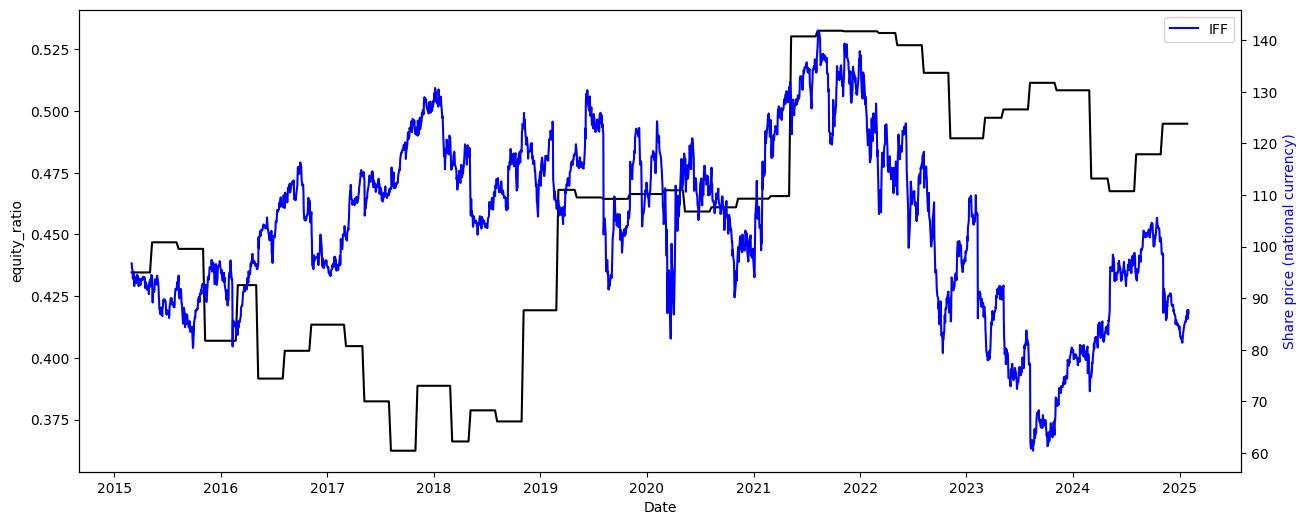

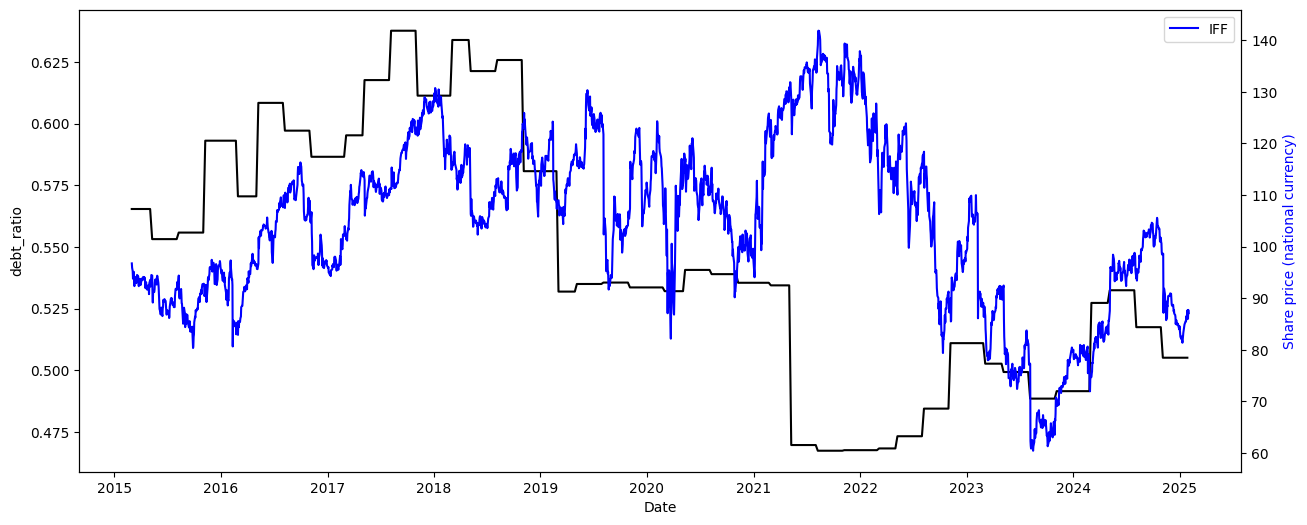

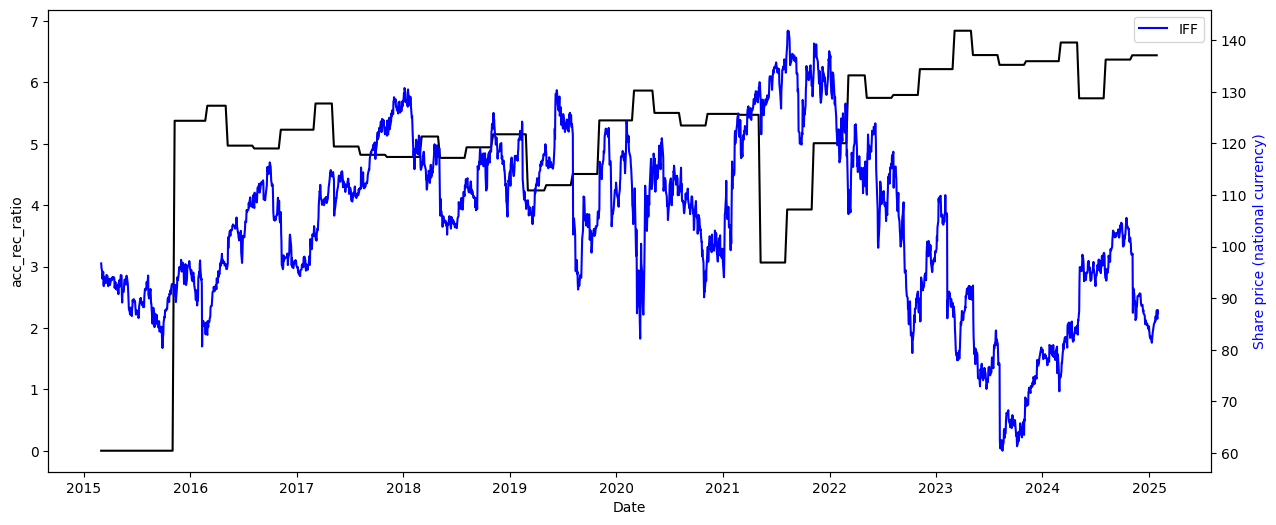

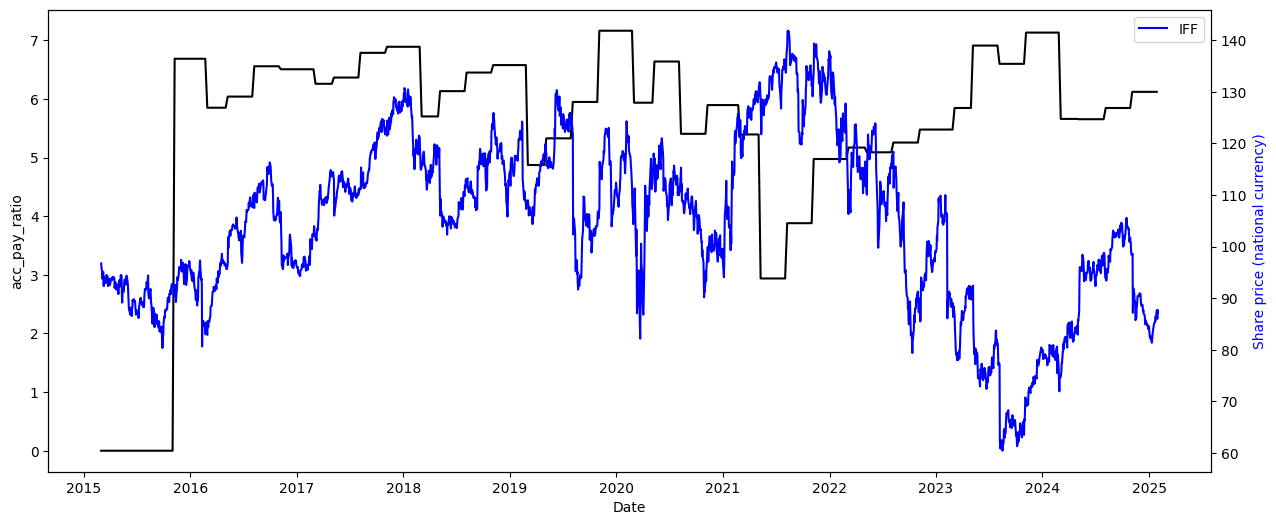

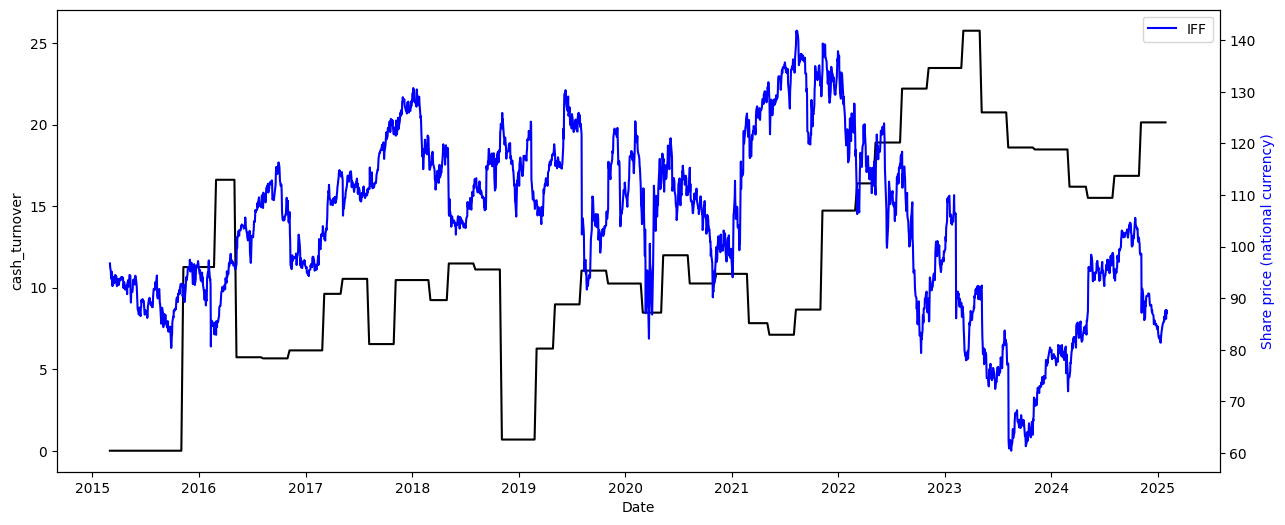

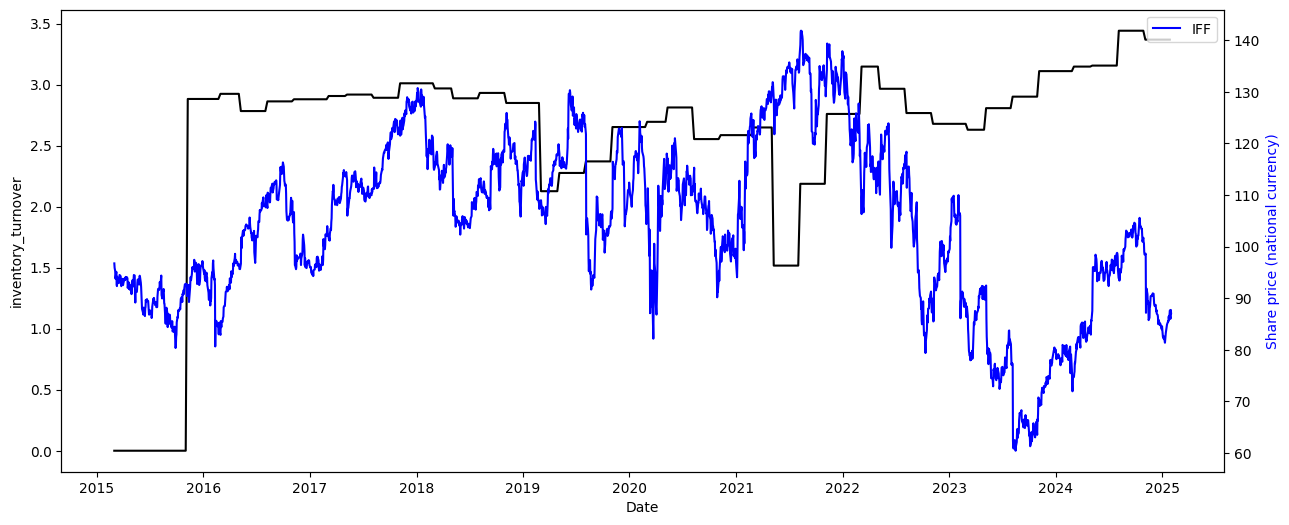

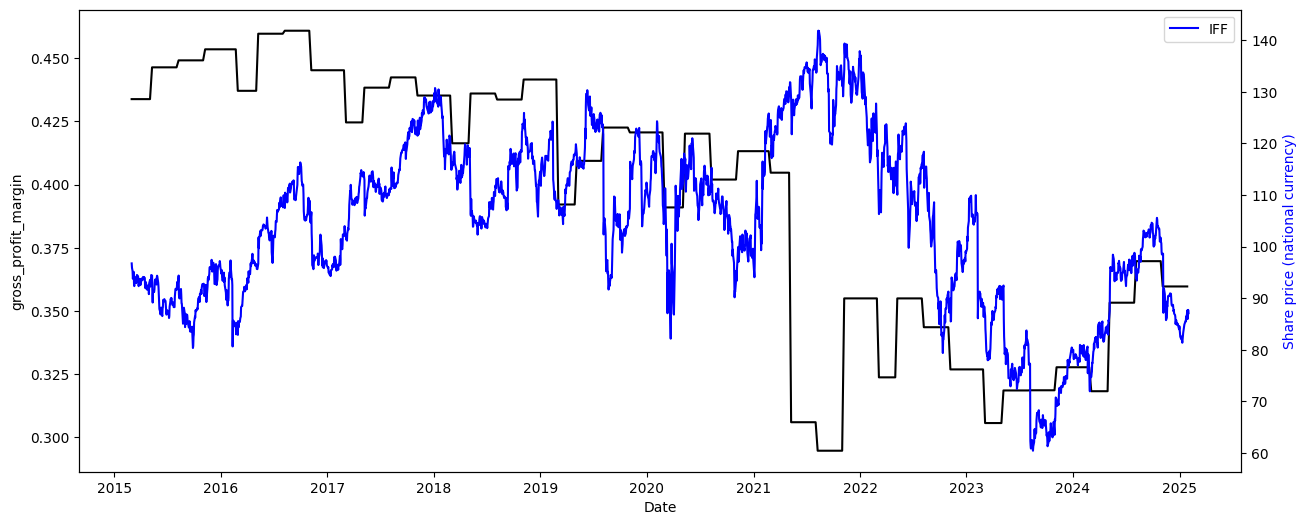

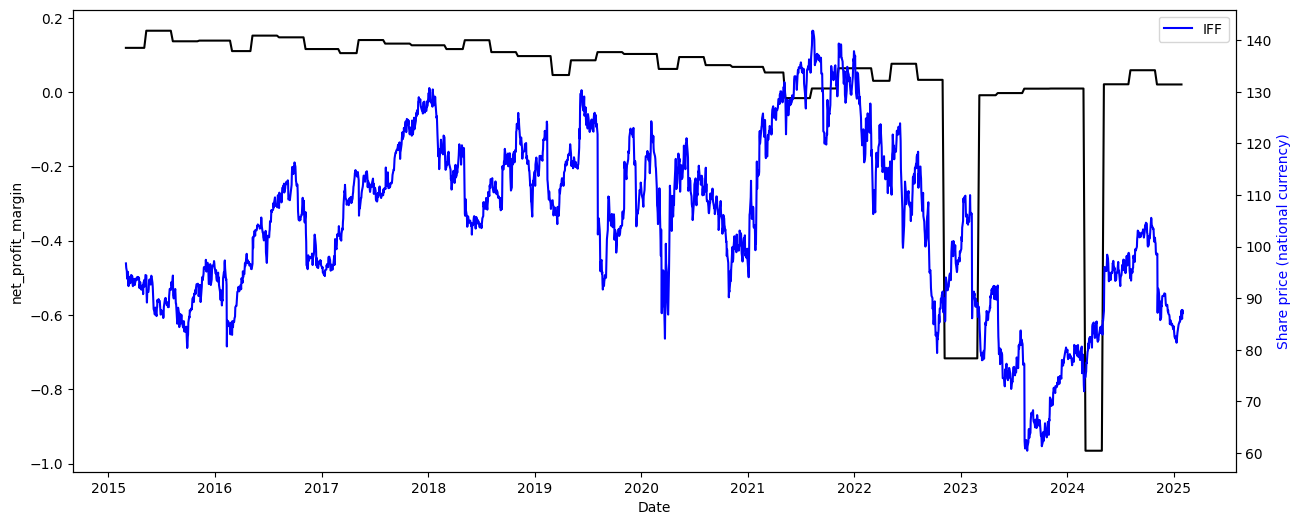

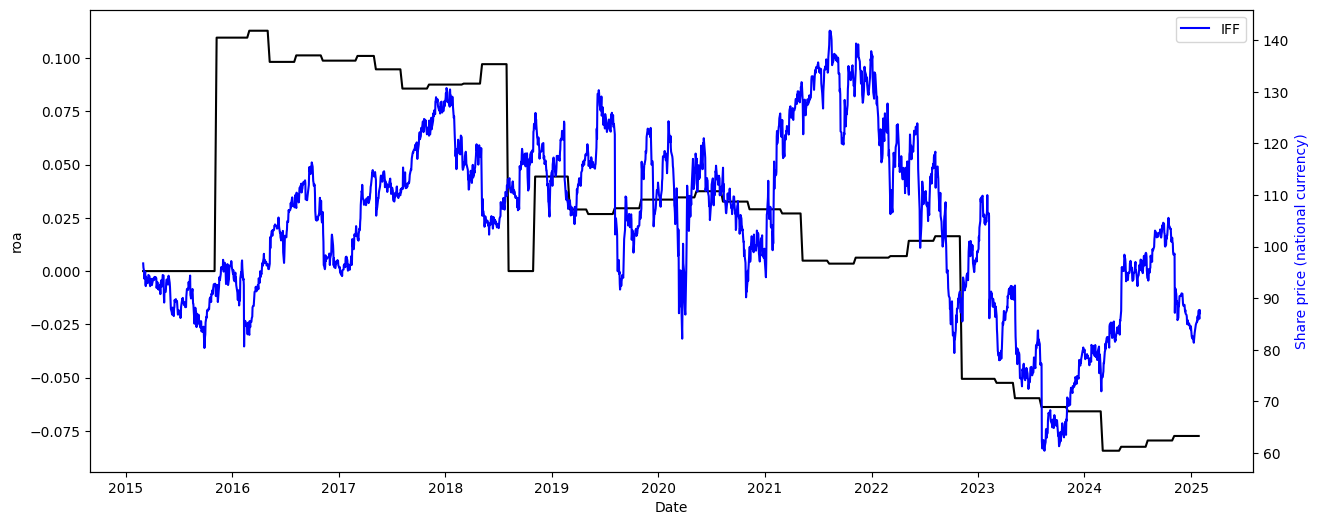

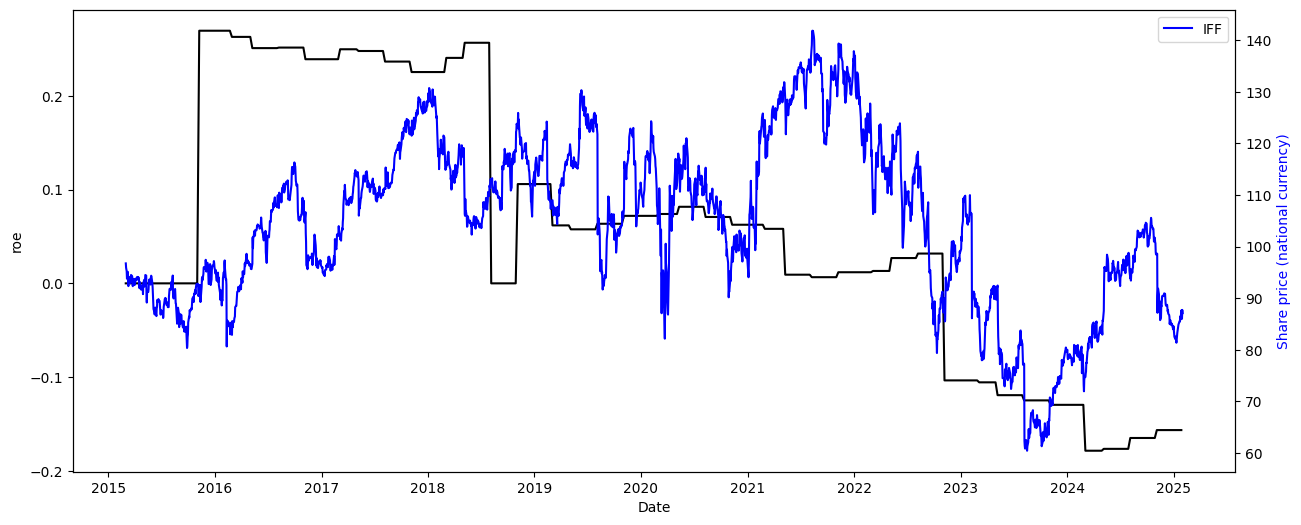

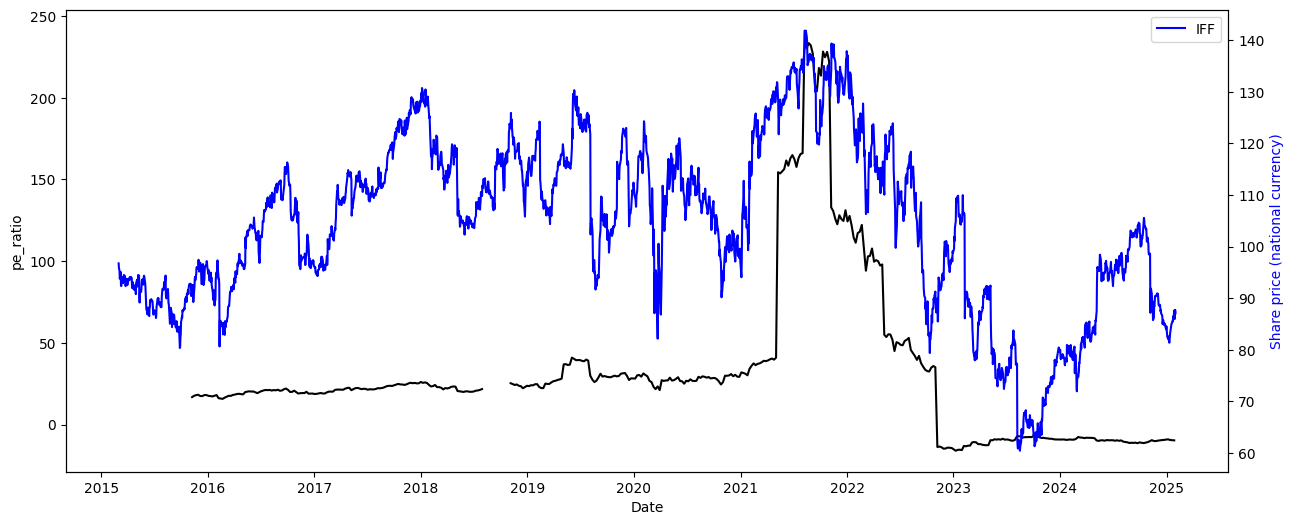

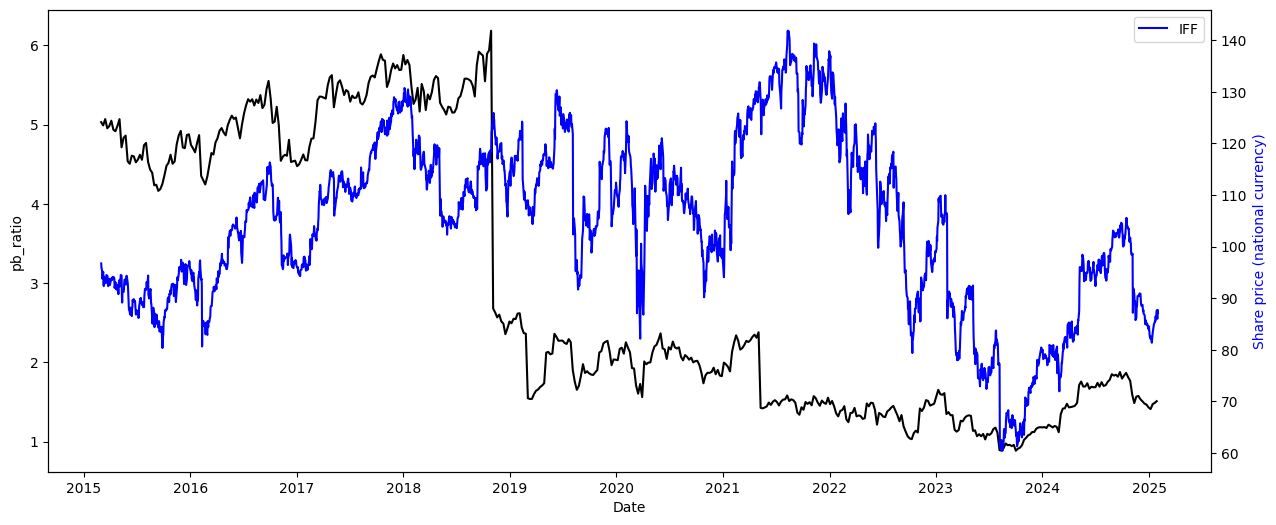

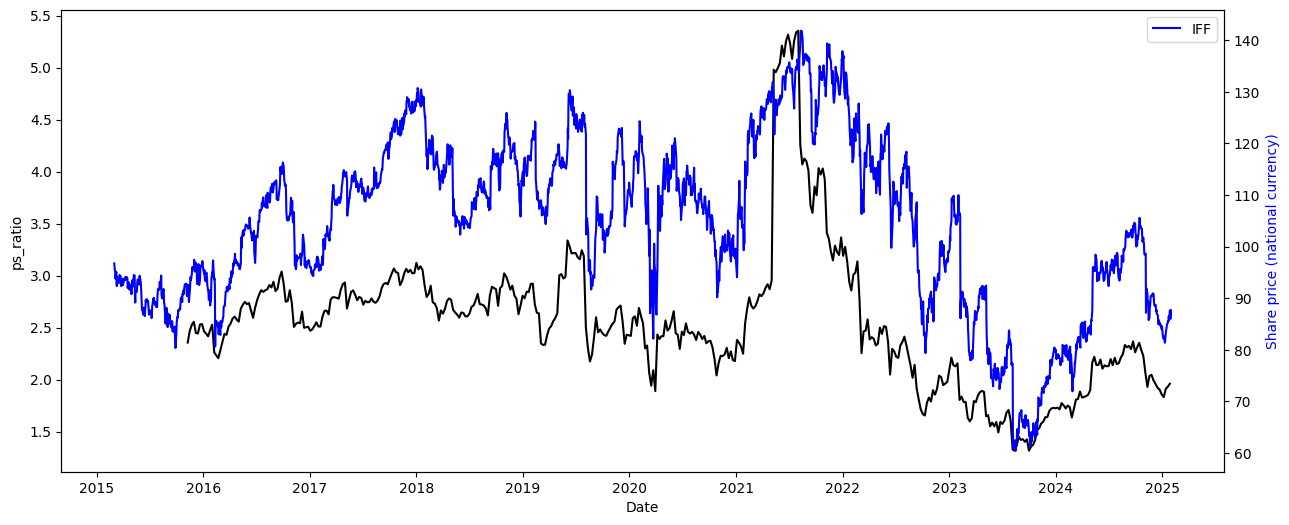

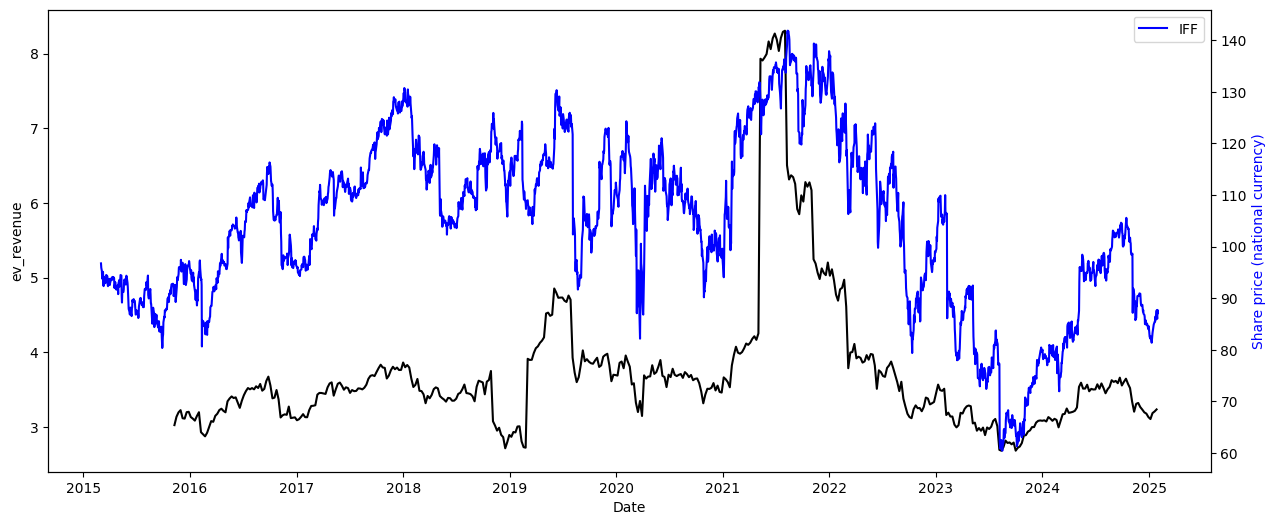

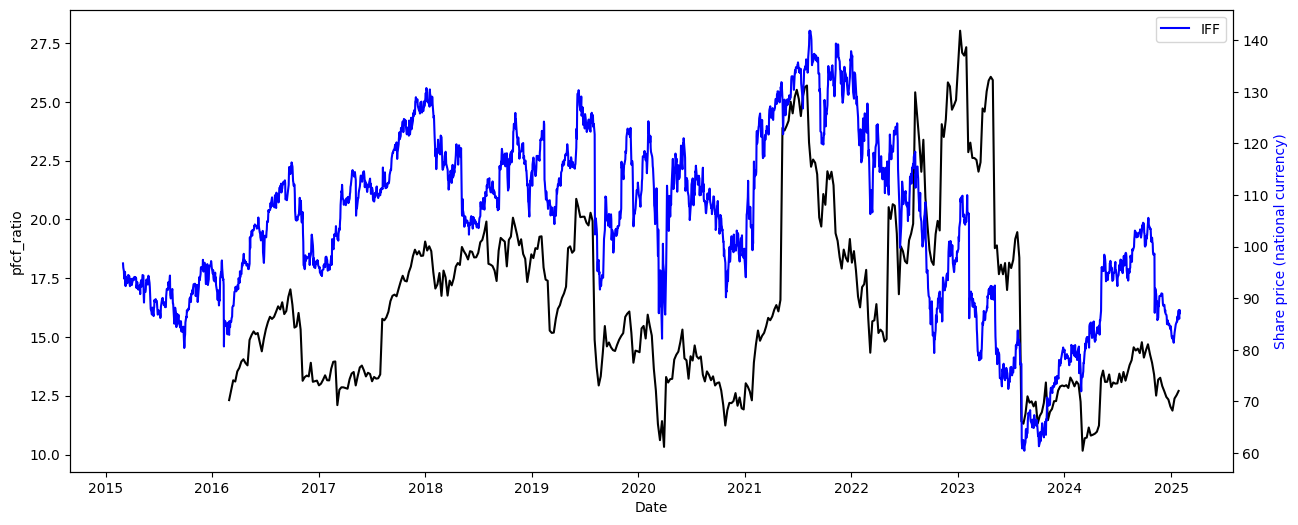

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

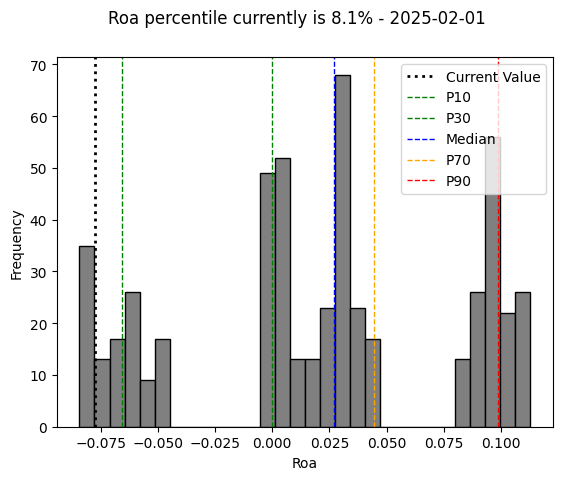

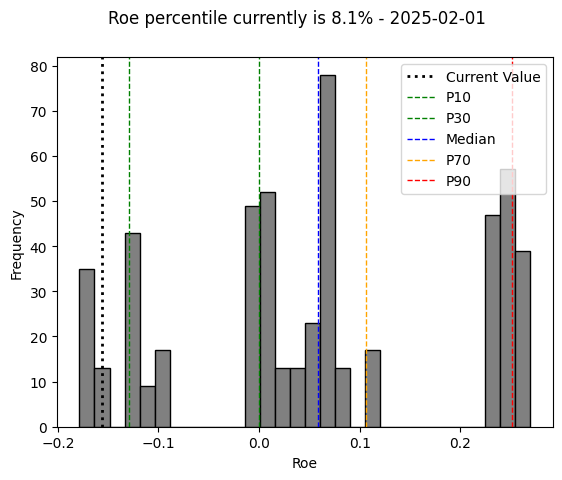

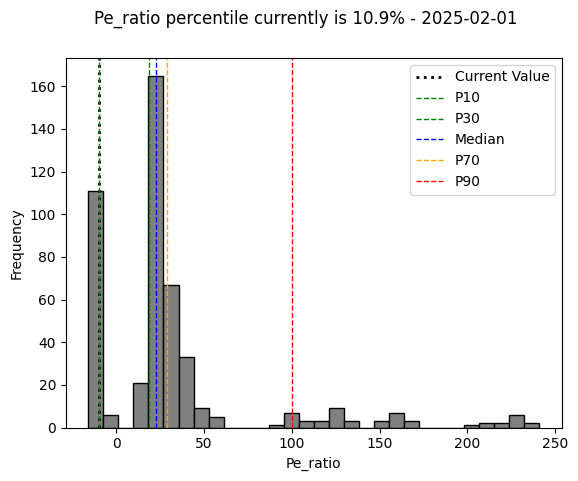

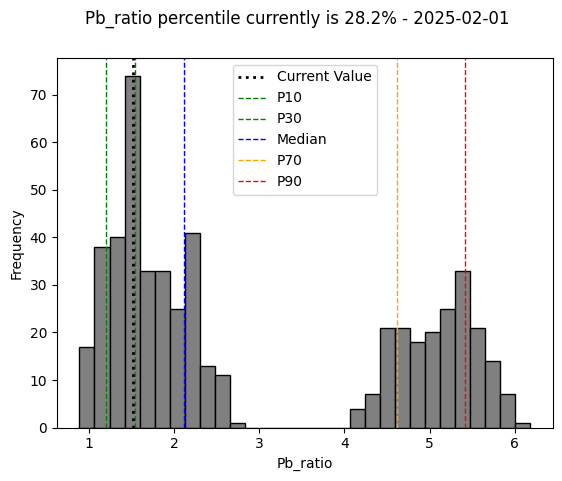

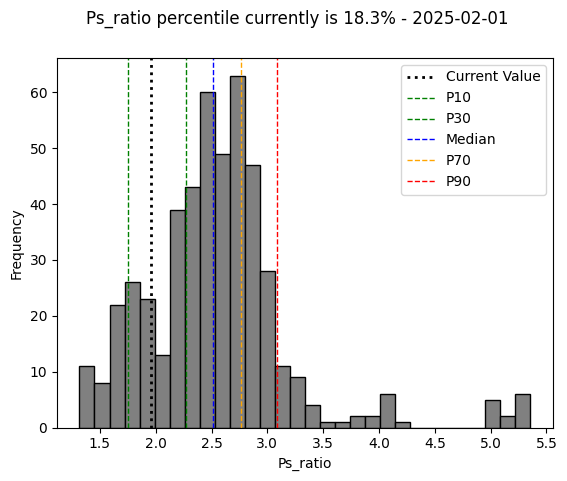

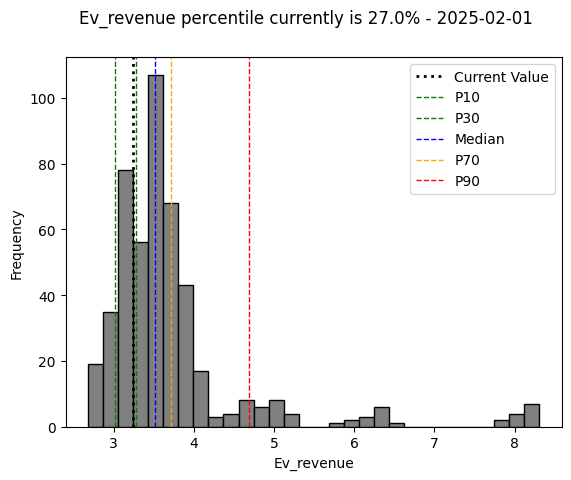

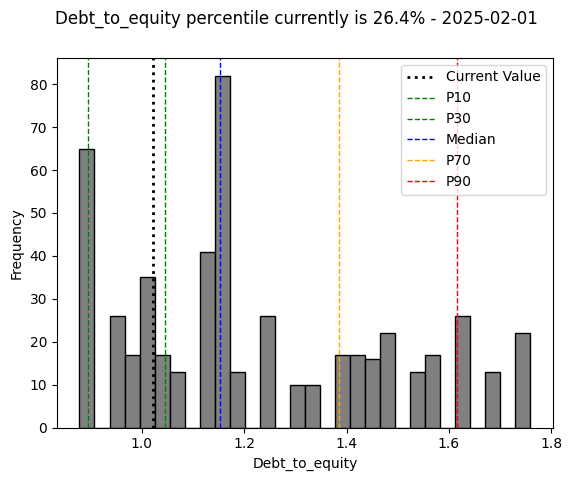

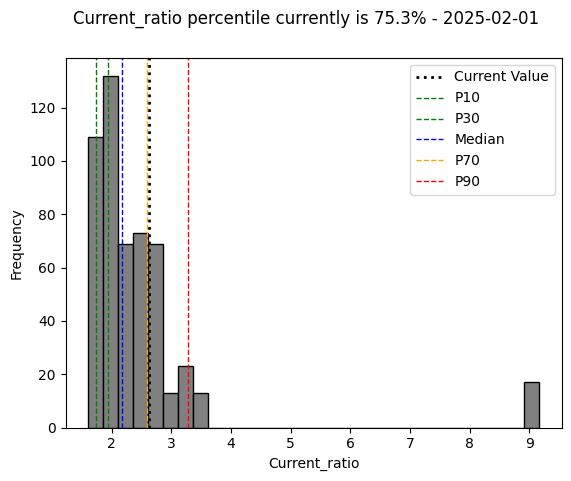

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.995560,0.142757,0.721509,0.392194,-0.012891,0.697456,0.141466
roe,0.995560,1.000000,0.100215,0.751473,0.368123,-0.047664,0.736953,0.133495
pe_ratio,0.142757,0.100215,1.000000,-0.139890,0.773864,0.847327,-0.310934,-0.044755
pb_ratio,0.721509,0.751473,-0.139890,1.000000,0.261967,-0.192552,0.917189,0.154584
ps_ratio,0.392194,0.368123,0.773864,0.261967,1.000000,0.858697,0.129636,0.125650
ev_revenue,-0.012891,-0.047664,0.847327,-0.192552,0.858697,1.000000,-0.333304,-0.172288
debt_to_equity,0.697456,0.736953,-0.310934,0.917189,0.129636,-0.333304,1.000000,0.256295
current_ratio,0.141466,0.133495,-0.044755,0.154584,0.125650,-0.172288,0.256295,1.000000


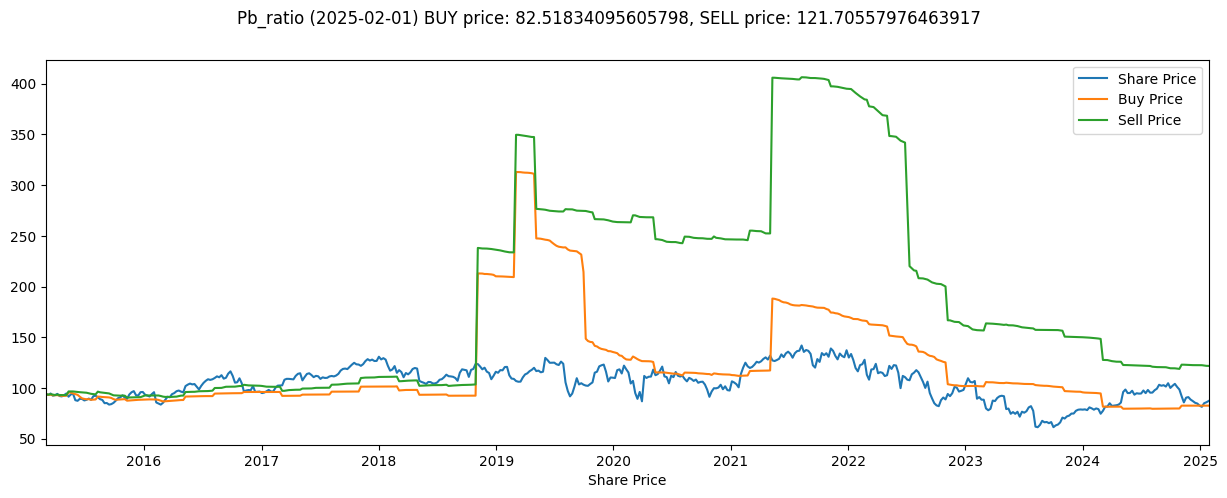

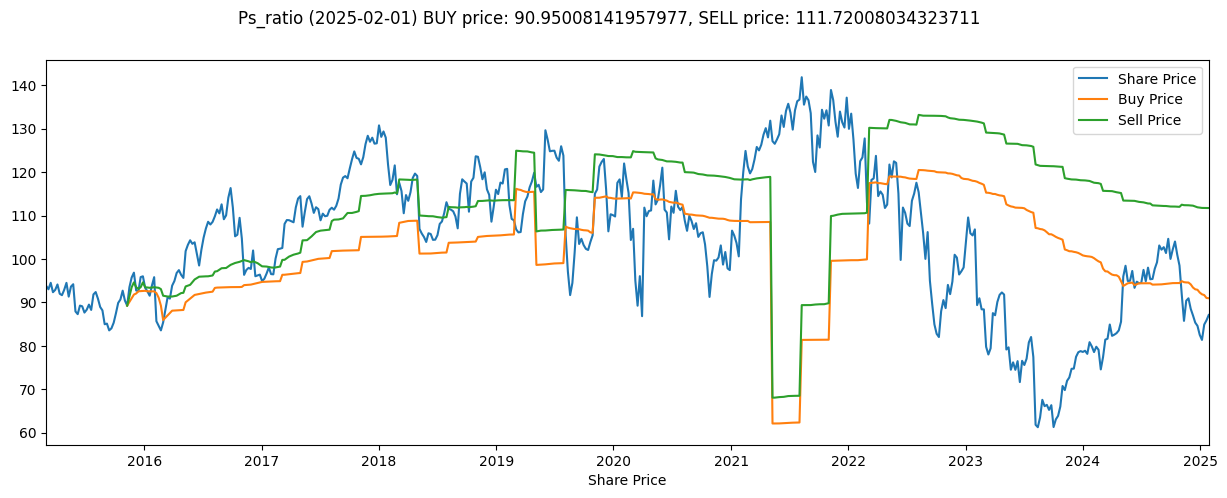

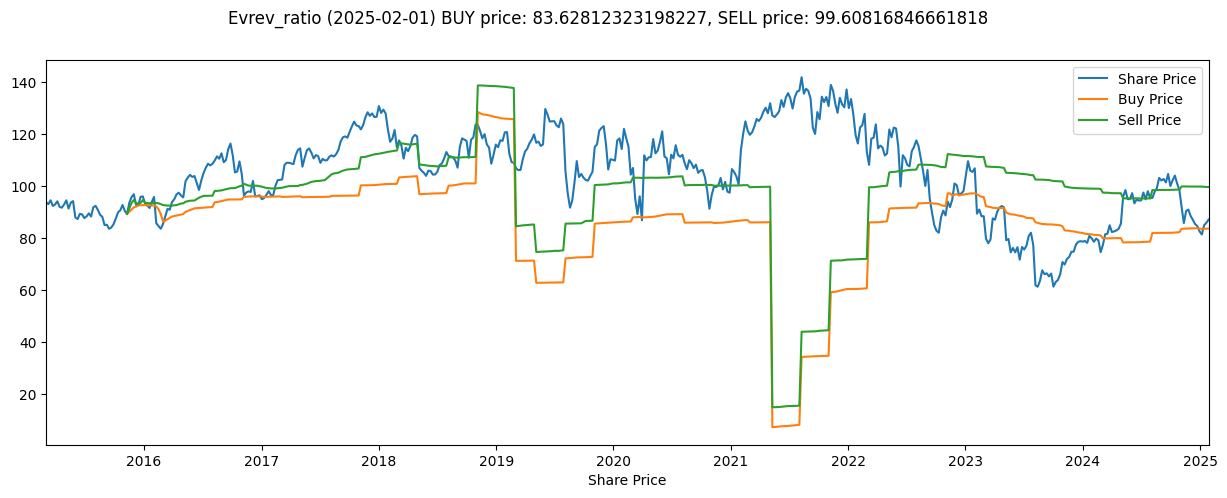

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)